## Github sensistivity analysis

Run on bbsn00, use global specialized version (all files) vs. hyper per file. single-threaded to count execution time.



In [1]:
import pandas as pd

In [2]:
data_path = '../data/github-sensitivity-results-bbsn00.csv'

In [3]:
df = pd.read_csv(data_path)

In [4]:
gdf = df.groupby(['mode', 'path'])['time'].aggregate(['mean', 'std']).reset_index()
gdf['date'] = pd.to_datetime(df['path'].apply(lambda path: path[path.rfind('/')+1:path.rfind('.')]))

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

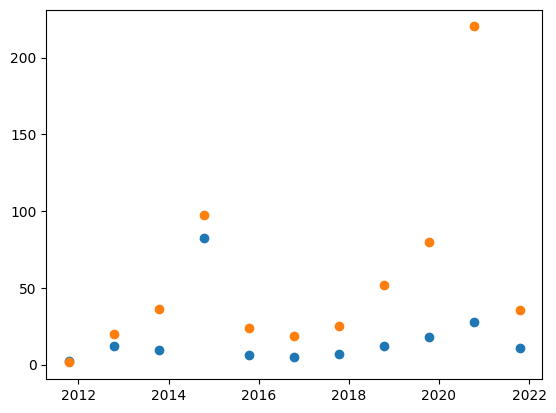

In [6]:
gdf_hyper = gdf[gdf['mode'] == 'hyper']
plt.scatter(gdf_hyper['date'], gdf_hyper['mean'], label='hyper')
gdf_global = gdf[gdf['mode'] == 'global']
plt.scatter(gdf_global['date'], gdf_global['mean'], label='global')

In [7]:
# now compute speedup factors


In [8]:
gdf = gdf.sort_values(by=['mode', 'date']).reset_index(drop=True)

In [9]:
speedups = gdf[gdf['mode'] == 'global']['mean'].values / gdf[gdf['mode'] == 'hyper']['mean'].values

In [10]:
sf_series = pd.Series(speedups, index=gdf[gdf['mode'] == 'hyper']['date'])

Text(0, 0.5, 'speedup factor (end-to-end time)')

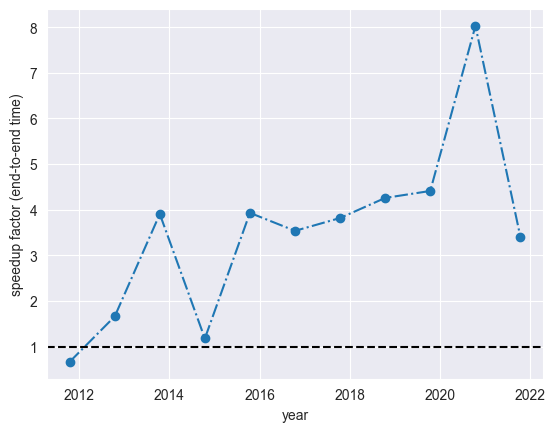

In [11]:
sns.set_style('darkgrid')
plt.plot(sf_series.index, sf_series, linestyle='-.', marker='o')
plt.axhline(1, linestyle='--', color='k')
plt.xlabel('year')
plt.ylabel('speedup factor (end-to-end time)')

In [12]:
import numpy as np

Text(0, 0.5, 'speedup factor (end-to-end time)')

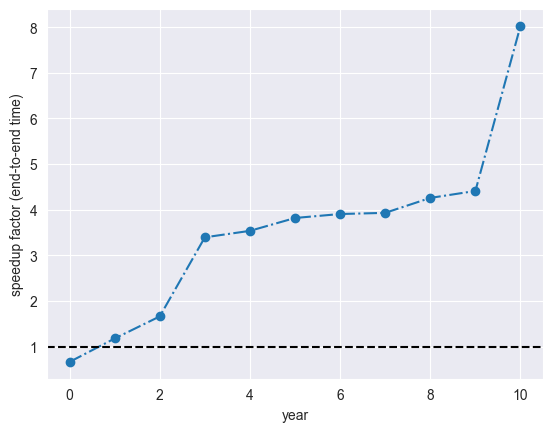

In [13]:
plt.plot(np.arange(len(sf_series)), sf_series.sort_values(), linestyle='-.', marker='o')
plt.axhline(1, linestyle='--', color='k')
plt.xlabel('year')
plt.ylabel('speedup factor (end-to-end time)')

In [14]:
#compute global speedup factor by adding up times

num_runs = df['run'].max() + 1
total_time = df.groupby(['mode'])['time'].sum() / num_runs
global_speedup = total_time.loc['global'] / total_time.loc['hyper']

join with file sizes

In [15]:
%%file meta_info.tsv
-rw-rw-r-- 1 501 staff    78478920 Sep 27 21:58 2011-10-15.json
-rw-rw-r-- 1 501 staff   213794112 Sep 27 21:58 2012-10-15.json
-rw-rw-r-- 1 501 staff   533607666 Sep 27 21:59 2013-10-15.json
-rw-rw-r-- 1 501 staff  2656017942 Sep 27 22:01 2014-10-15.json
-rw-rw-r-- 1 501 staff  2102880576 Sep 27 22:04 2015-10-15.json
-rw-rw-r-- 1 501 staff  1611649363 Sep 27 22:05 2016-10-15.json
-rw-rw-r-- 1 501 staff  2204545177 Sep 27 22:08 2017-10-15.json
-rw-rw-r-- 1 501 staff  4857228670 Sep 27 22:14 2018-10-15.json
-rw-rw-r-- 1 501 staff  7798708474 Sep 27 22:22 2019-10-15.json
-rw-rw-r-- 1 501 staff 12445448390 Sep 27 22:36 2020-10-15.json
-rw-rw-r-- 1 501 staff  3573656628 Sep 27 22:40 2021-10-15.json

Overwriting meta_info.tsv


In [16]:
with open('meta_info.tsv') as fp:
    lines = fp.readlines()
tmp_arr = [line.split() for line in lines]
tmp_data = [(int(L[4]), L[-1].replace('.json', '')) for L in tmp_arr]
df_meta = pd.DataFrame(tmp_data, columns=['size', 'date'])
df_meta['date'] = pd.to_datetime(df_meta['date'])

In [17]:
df_merged = pd.merge(gdf, df_meta, on='date')

In [18]:
# no compute the same factor ONLY for execution time and then could compute the effect of parallelization

In [19]:
df_sizes = df_merged[['date', 'size']].drop_duplicates().set_index('date')
tmp_df = pd.concat((df_sizes, sf_series), axis=1)
tmp_df = tmp_df.reset_index()
tmp_df.columns = ['date', 'size', 'speedup']
tmp_df = tmp_df.sort_values(by='size').reset_index(drop=True)

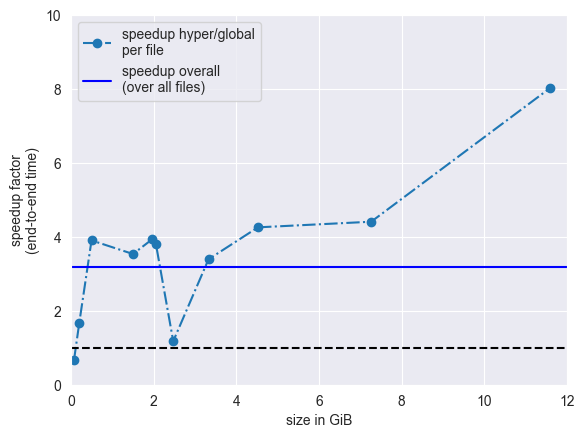

In [20]:
mem_factor= 1024 * 1024 * 1024
plt.plot(tmp_df['size'] / mem_factor, tmp_df['speedup'], linestyle='-.', marker='o', label='speedup hyper/global\nper file')
plt.axhline(1, linestyle='--', color='k')
plt.axhline(global_speedup, color='b', label='speedup overall\n(over all files)')
plt.xlabel('size in GiB')
plt.ylabel('speedup factor\n(end-to-end time)')
plt.ylim(0, 10)
plt.xlim(0, 12)
plt.legend(loc='best')

Extract more information from data:

In [21]:
size_lookup_dict = {str(d['date'])[:10] : d['size'] for d in tmp_df.to_dict('records')}
size_lookup_dict

{'2011-10-15': 78478920,
 '2012-10-15': 213794112,
 '2013-10-15': 533607666,
 '2016-10-15': 1611649363,
 '2015-10-15': 2102880576,
 '2017-10-15': 2204545177,
 '2014-10-15': 2656017942,
 '2021-10-15': 3573656628,
 '2018-10-15': 4857228670,
 '2019-10-15': 7798708474,
 '2020-10-15': 12445448390}

In [22]:
df['input_row_count'] = df['stats'].apply(lambda x: json.loads(x)['input']['total_input_row_count'])

In [23]:
for k in ["fast_path_execution_time",
          "general_and_interpreter_time",
          "compile_time",
          "hyperspecialization_time"]:
    df[k] = df['stats'].apply(lambda x: json.loads(x)['timings'].get(k))

In [24]:
def size_from_path(path):
    path = os.path.basename(path)
    path = path.replace('.json', '')
    return size_lookup_dict[path]
    
df['size'] = df['path'].apply(size_from_path)

In [25]:
mu_df = df.groupby(['mode', 'path']).mean().sort_values(by='input_row_count').reset_index()

/var/folders/l7/8zgzcszx7z5gk7kk92f6nc1c0000gn/T/ipykernel_1516/2905200233.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mu_df = df.groupby(['mode', 'path']).mean().sort_values(by='input_row_count').reset_index()


In [26]:
mu_df['date'] = pd.to_datetime(mu_df['path'].apply(lambda path: path[path.rfind('/')+1:path.rfind('.')]))

In [27]:
mu_df_global = mu_df[mu_df['mode'] == 'global']
mu_df_hyper = mu_df[mu_df['mode'] == 'hyper']

/var/folders/l7/8zgzcszx7z5gk7kk92f6nc1c0000gn/T/ipykernel_1516/248975752.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)


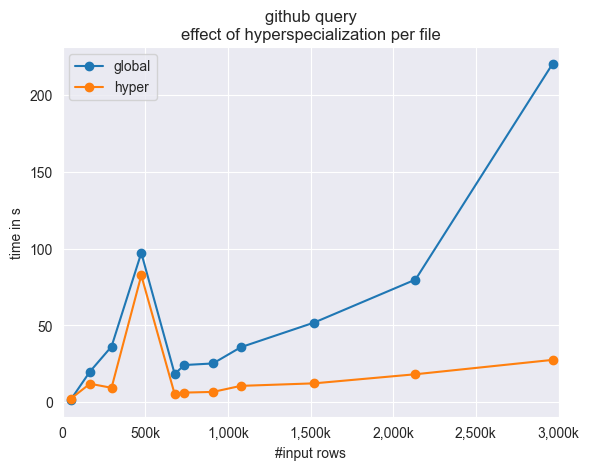

In [28]:
plt.plot(mu_df_global['input_row_count'], mu_df_global['time'], marker='o', label='global')
plt.plot(mu_df_hyper['input_row_count'], mu_df_hyper['time'], marker='o', label='hyper')
plt.xlabel('#input rows')
plt.xlim(0, 3000 * 1000)
ax = plt.gca()
xlabels = ['{:,}'.format(int(x)) + 'k' if x != 0 else '0' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
plt.ylabel('time in s')
plt.legend(loc='best')
plt.title('github query\neffect of hyperspecialization per file')

print()

In [38]:
mu_df_hyper = mu_df_hyper.sort_values(by='date').reset_index()

In [44]:
mu_df_hyper.head()

,index,mode,path,run,time,input_row_count,fast_path_execution_time,general_and_interpreter_time,compile_time,hyperspecialization_time,size,date
0,1,hyper,/hot/data/github_daily/2011-10-15.json,1.5,2.046333,48899.0,0.235191,0.072356,0.049957,1.570200,7.847892e+07,2011-10-15
1,3,hyper,/hot/data/github_daily/2012-10-15.json,1.5,11.916725,165692.0,1.132998,8.491088,0.114547,2.085703,2.137941e+08,2012-10-15
2,5,hyper,/hot/data/github_daily/2013-10-15.json,1.5,9.258895,296456.0,2.097903,5.147358,0.111935,1.806965,5.336077e+08,2013-10-15
3,7,hyper,/hot/data/github_daily/2014-10-15.json,1.5,82.505500,476393.0,17.732450,62.778950,0.362512,1.534682,2.656018e+09,2014-10-15
4,11,hyper,/hot/data/github_daily/2015-10-15.json,1.5,6.132733,737714.0,4.528395,0.000011,0.048659,1.448752,2.102881e+09,2015-10-15


/var/folders/l7/8zgzcszx7z5gk7kk92f6nc1c0000gn/T/ipykernel_1516/1855314772.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


Text(0.5, 0.98, 'Github - Hyper mode')

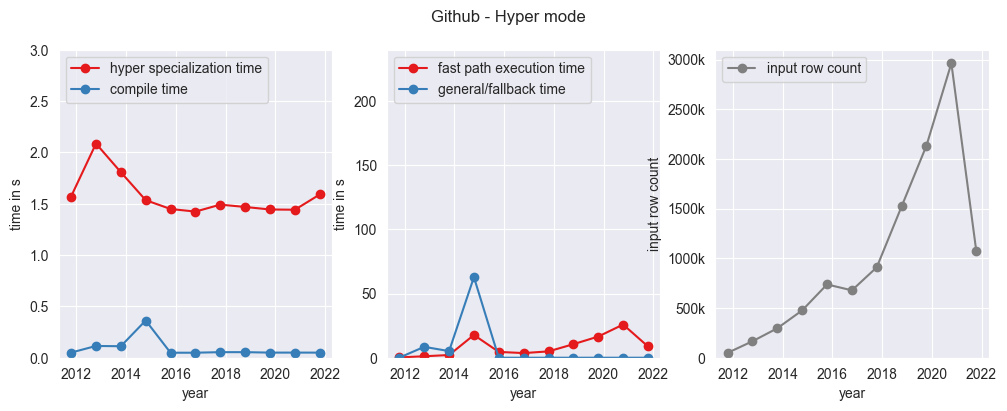

In [91]:
sns.set_palette(sns.color_palette("Set1"))

fig = plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(mu_df_hyper['date'], mu_df_hyper['hyperspecialization_time'],
         marker='o', label='hyper specialization time')
plt.plot(mu_df_hyper['date'], mu_df_hyper['compile_time'], marker='o', label='compile time')

plt.legend(loc='best')
plt.ylim(0, 3)
plt.ylabel('time in s')
plt.xlabel('year')
plt.legend(loc='upper left')

plt.subplot(132)

plt.plot(mu_df_hyper['date'], mu_df_hyper['fast_path_execution_time'],
         marker='o', label='fast path execution time')
plt.plot(mu_df_hyper['date'], mu_df_hyper['general_and_interpreter_time'], marker='o', label='general/fallback time')
plt.xlabel('year')
plt.ylabel('time in s')
plt.legend(loc='upper left')
plt.ylim(0, 3 * 80)

plt.subplot(133)
plt.plot(mu_df_hyper['date'], mu_df_hyper['input_row_count'],
         marker='o', label='input row count', color=[0.5, 0.5, 0.5])
plt.ylim(0, 3100 * 1000)
ax = plt.gca()
ylabels = ['{:}'.format(int(y)) + 'k' if y != 0 else '0' for y in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels)
plt.ylabel('input row count')
plt.xlabel('year')
plt.legend(loc='upper left')

fig.suptitle('Github - Hyper mode')

In [66]:
mu_df_global = mu_df_global.sort_values(by='date').reset_index()

/var/folders/l7/8zgzcszx7z5gk7kk92f6nc1c0000gn/T/ipykernel_1516/2660906779.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


Text(0.5, 0.98, 'Github - Global mode')

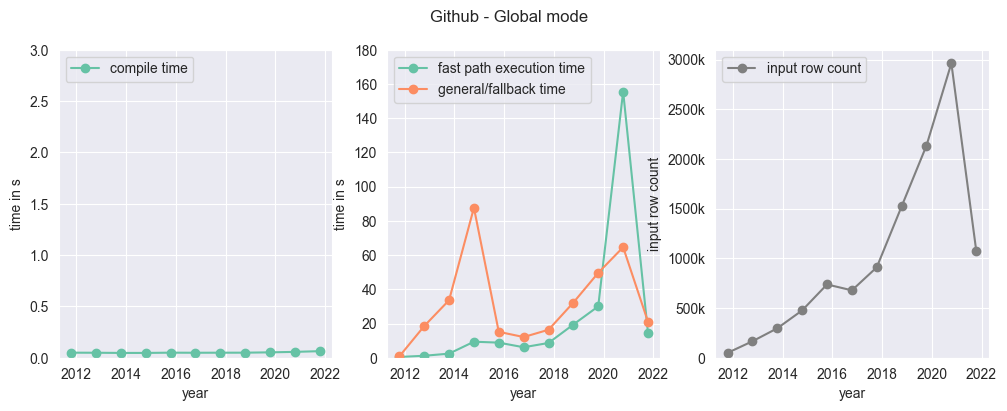

In [90]:
sns.set_palette(sns.color_palette("Set2"))
fig = plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(mu_df_global['date'], mu_df_global['compile_time'], marker='o', label='compile time')

plt.legend(loc='best')
plt.ylim(0, 3)
plt.ylabel('time in s')
plt.xlabel('year')
plt.legend(loc='upper left')

plt.subplot(132)

plt.plot(mu_df_hyper['date'], mu_df_global['fast_path_execution_time'],
         marker='o', label='fast path execution time')
plt.plot(mu_df_hyper['date'], mu_df_global['general_and_interpreter_time'], marker='o',
         label='general/fallback time')
plt.xlabel('year')
plt.ylabel('time in s')
plt.legend(loc='upper left')
plt.ylim(0, 3 * 60)

plt.subplot(133)
plt.plot(mu_df_global['date'], mu_df_global['input_row_count'],
         marker='o', label='input row count', color=[0.5, 0.5, 0.5])
plt.ylim(0, 3100 * 1000)
ax = plt.gca()
ylabels = ['{:}'.format(int(y)) + 'k' if y != 0 else '0' for y in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels)
plt.ylabel('input row count')
plt.xlabel('year')
plt.legend(loc='upper left')

fig.suptitle('Github - Global mode')

In [21]:
df[df['path'] == '/hot/data/github_daily/2014-10-15.json'][['time', 'mode', 'stats']].values

array([[77.6332, 'hyper',
        '{"input":{"input_file_count":1,"total_input_row_count":476393,"normal":155365,"general":637,"fallback":320391,"unresolved":0},"output":{"normal":16014,"except":0},"timings":{"fast_path_execution_time":17.0582,"general_and_interpreter_time":58.7689,"compile_time":0.360035,"hyperspecialization_time":1.35676},"hyper_active":true}'],
       [95.6118, 'global',
        '{"input":{"input_file_count":1,"total_input_row_count":476393,"normal":0,"general":637,"fallback":475756,"unresolved":0},"output":{"normal":16014,"except":0},"timings":{"fast_path_execution_time":8.80085,"general_and_interpreter_time":86.6627,"compile_time":0.0468996},"hyper_active":false}'],
       [83.9729, 'hyper',
        '{"input":{"input_file_count":1,"total_input_row_count":476393,"normal":155365,"general":637,"fallback":320391,"unresolved":0},"output":{"normal":16014,"except":0},"timings":{"fast_path_execution_time":20.3971,"general_and_interpreter_time":61.5135,"compile_time":0.374

In [120]:
df

,mode,path,run,time,stats
0,hyper,/hot/data/github_daily/2011-10-15.json,0,1.48427,"{""input"":{""input_file_count"":1,""total_input_ro..."
1,hyper,/hot/data/github_daily/2012-10-15.json,0,11.48860,"{""input"":{""input_file_count"":1,""total_input_ro..."
2,hyper,/hot/data/github_daily/2013-10-15.json,0,9.09437,"{""input"":{""input_file_count"":1,""total_input_ro..."
3,hyper,/hot/data/github_daily/2014-10-15.json,0,77.63320,"{""input"":{""input_file_count"":1,""total_input_ro..."
4,hyper,/hot/data/github_daily/2015-10-15.json,0,5.91079,"{""input"":{""input_file_count"":1,""total_input_ro..."
...,...,...,...,...,...
83,global,/hot/data/github_daily/2017-10-15.json,3,24.77550,"{""input"":{""input_file_count"":1,""total_input_ro..."
84,global,/hot/data/github_daily/2018-10-15.json,3,52.89940,"{""input"":{""input_file_count"":1,""total_input_ro..."
85,global,/hot/data/github_daily/2019-10-15.json,3,77.98330,"{""input"":{""input_file_count"":1,""total_input_ro..."
86,global,/hot/data/github_daily/2020-10-15.json,3,245.62500,"{""input"":{""input_file_count"":1,""total_input_ro..."
